Attempting to reproduce results similar to tau statistics from figure 9 found here: https://arxiv.org/pdf/2011.03408

In particular, we are interested in reproducing fit parameter values found in Table 2.
We find when using the data vectors generated from FLASK provided to us, we find results reasonably close to published values with our methodology. However, the fit values gleaned from statistics measured directly from data veer too far away from the published values to be satisfied with our result--especially eta. 

We show the functions below used to measure this statistic.

In [1]:
import numpy as np
import treecorr
import corner
import emcee
from scipy.stats import qmc
import h5py
import matplotlib.pyplot as plt

In [2]:
def load_rowe():
    '''
    loads calculated rowe statistics for fitting
    '''
    rowe_stats = {}
    import numpy as np
    with h5py.File('../../temp/TXPipe/data/desy3/outputs/rowe_stats.hdf5') as f:
        for i in 0, 1, 2, 3, 4, 5:
            theta   = f['rowe_statistics'][f"rowe_{i}_PSF-reserved"]['theta'][:]
            xi_plus = f['rowe_statistics'][f"rowe_{i}_PSF-reserved"]['xi_plus'][:]
            xi_minus= f['rowe_statistics'][f"rowe_{i}_PSF-reserved"]['xi_minus'][:]
            xi_err  = f['rowe_statistics'][f"rowe_{i}_PSF-reserved"]['xi_err'][:]

            rowe_stats[i] = theta, xi_plus,xi_minus, xi_err
        
    return rowe_stats

In [3]:
def chi2(params,tau_stats,rowe_stats,covtau):
        '''
        calculates reduced chi^2 value for checking fitting parameters
        '''
        alpha,beta,eta = params
        
        _, rowe0p, rowe0m,_  = rowe_stats[0]
        _, rowe1p, rowe1m,_  = rowe_stats[1]
        _, rowe2p, rowe2m,_  = rowe_stats[2]
        _, rowe3p, rowe3m,_  = rowe_stats[3]
        _, rowe4p, rowe4m,_  = rowe_stats[4]
        _, rowe5p, rowe5m,_  = rowe_stats[5]
       
        _, tau0p, tau0m, tau2p, tau2m, tau5p, tau5m, _  = tau_stats
        
        
        # Create combined template
        T0p    = alpha*rowe0p + beta*rowe2p + eta*rowe5p
        T0m    = alpha*rowe0m + beta*rowe2m + eta*rowe5m
        T2p    = alpha*rowe2p + beta*rowe1p + eta*rowe4p
        T2m    = alpha*rowe2m + beta*rowe1m + eta*rowe4m
        T5p    = alpha*rowe5p + beta*rowe4p + eta*rowe3p
        T5m    = alpha*rowe5m + beta*rowe4m + eta*rowe3m        
        # Create data and template vector
        Tall  = np.concatenate([T0p,T0m,T2p,T2m,T5p,T5m])
        Xall  = np.concatenate([tau0p,tau0m,tau2p,tau2m,tau5p,tau5m])
        
        x = Xall-Tall
        chi2 = np.matmul(x,np.matmul(np.linalg.inv(covtau),x))/len(x)
        return chi2

In [4]:
def sample(tau_stats, rowe_stats, ranges, nwalkers=150, ndim=3):
        '''
        Run a simple mcmc chain to determine the best-fit values 
        '''
        import emcee
        from scipy.stats import qmc

        sampler = qmc.LatinHypercube(d=3, optimization="random-cd")
        sample  = sampler.random(n=nwalkers)
        
        initpos = qmc.scale(sample, [ ranges['alpha'][0], ranges['beta'][0], ranges['eta'][0] ],
                                    [ ranges['alpha'][1], ranges['beta'][1], ranges['eta'][1] ])

        ret = {}
        var = ['alpha','beta','eta']

        print("Computing best-fit alpha, beta, eta")
        _, _, _, _, _, _, _, cov = tau_stats

        mask = cov.diagonal() > 0
        cov = cov[mask][:, mask]
        f_H = 1.*(300-120-2)/(300-1)
        f_DS = 1/(1+(120-3)*(300-120-2)/(300-120-1)/(300-120-4))
        cov = cov / f_H / f_DS 
        invcov      = np.linalg.inv(cov)
        
        sampler = emcee.EnsembleSampler(nwalkers, ndim, logProb, args=(tau_stats, rowe_stats, ranges,invcov, mask))
        sampler.run_mcmc(initpos, 5000, progress=True);

        flat_samples = sampler.get_chain(discard=2000, flat=True)
        print(np.shape(flat_samples))
        for i,v in enumerate(var):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q    = np.diff(mcmc)
            ret[v] = {'median': mcmc[1],'lerr': q[0], 'rerr': q[1]}
            
        print ("chi2:",chi2([ret['alpha']['median'],ret['beta']['median'],ret['eta']['median']],tau_stats,rowe_stats,cov))
        
        fig = corner.corner(flat_samples, labels=var,
                        quantiles=[0.16, 0.5, 0.84],  
                        levels=(1-np.exp(-0.5), 1-np.exp(-2), 1-np.exp(-9./2)),
                        show_titles=True, title_kwargs={"fontsize": 12}, title_fmt= '.4f', 
                        smooth1d=None, plot_contours=True,  
                        no_fill_contours=False, plot_density=True, use_math_text=True, )
        fig.show()
        return ret


In [5]:
def logPrior(theta,ranges):
        '''
        If parameter in defined range return 0, otherwise -np.inf
        '''
        alpha, beta, eta = theta

        if (ranges['alpha'][0] < alpha < ranges['alpha'][1]) and (ranges['beta'][0] < beta < ranges['beta'][1]) and (ranges['eta'][0] < eta < ranges['eta'][1]):
            return 0.0
        return -np.inf


def logLike(theta, tau_stats, rowe_stats, invcov, mask):
    '''
    Compute likelihood
    theta     : parameters
    tau_stats : Measured tau stats
    rowe_stats: Measured rowe stats to be used for Tau 
    invcov    : Inverse covariance matrix 
    '''

    # Load parameters
    alpha, beta, eta = theta

    # Load rowe and tau
    _, rowe0p, rowe0m,_  = rowe_stats[0]
    _, rowe1p, rowe1m,_  = rowe_stats[1]
    _, rowe2p, rowe2m,_  = rowe_stats[2]
    _, rowe3p, rowe3m,_  = rowe_stats[3]
    _, rowe4p, rowe4m,_  = rowe_stats[4]
    _, rowe5p, rowe5m,_  = rowe_stats[5]


    _, tau0p, tau0m, tau2p, tau2m, tau5p, tau5m, _  = tau_stats

    # Create combined template
    T0p    = alpha*rowe0p + beta*rowe2p + eta*rowe5p
    T0m    = alpha*rowe0m + beta*rowe2m + eta*rowe5m
    T2p    = alpha*rowe2p + beta*rowe1p + eta*rowe4p
    T2m    = alpha*rowe2m + beta*rowe1m + eta*rowe4m
    T5p    = alpha*rowe5p + beta*rowe4p + eta*rowe3p
    T5m    = alpha*rowe5m + beta*rowe4m + eta*rowe3m

    # Create data and template vector
    Tall  = np.concatenate([T0p,T0m,T2p,T2m,T5p,T5m])[mask]
    Xall  = np.concatenate([tau0p,tau0m,tau2p,tau2m,tau5p,tau5m])[mask]

    return -0.5*np.dot(Xall-Tall,np.dot(Xall-Tall,invcov))


def logProb(theta, tau_stats, rowe_stats, ranges, invcov, mask):
    lp = logPrior(theta,ranges)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLike(theta, tau_stats, rowe_stats, invcov, mask)

In [6]:
def compute_all_tau(gra, gdec, g, gw, sra, sdec, e_psf, e_mod, de_psf, T_f):
        '''
        Compute tau0, tau2, tau5.
        All three needs to be computed at once due to covariance.

        gra    : RA of galaxies
        gdec   : DEC of galaxies
        g      : shear for observed galaxies np.array((e1, e2)
        gw     : weights

        s      : indices of stars to use in calculation
        sra    : RA of stars
        sdec   : DEC of stars
        
        e_psf  : measured ellipticities of PSF from stars -- np.array((e1psf, e2psf))
        e_mod  : model ellipticities of PSF               -- np.array((e1mod, e2mod))
        de_psf : e_psf-e_mod                              -- np.array((e1psf, e2psf))
        T_f    : (T_meas - T_model)/T_meas                -- np.array((e1psf, e2psf))
        
        NOTE   : mean subtraction yields incorrect results still 
        '''
        
        import treecorr
        
        p = e_mod
        q = de_psf
        w = e_psf * T_f
        
        p = np.array(( [p[0], p[1]]))     
        q = np.array(( [q[0], q[1]]))     
        w = np.array(( [w[0], w[1]]))     

        print(f"Computing Tau 0,2,5 and the covariance")
        
        # Load all catalogs
        catg = treecorr.Catalog(ra=gra, dec=gdec, g1=g[0], g2=g[1], w=gw, ra_units="deg", dec_units="deg",npatch=300) # galaxy shear
        catp = treecorr.Catalog(ra=sra, dec=sdec, g1=p[0], g2=p[1], ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # e_model
        catq = treecorr.Catalog(ra=sra, dec=sdec, g1=q[0], g2=q[1], ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # (e_* - e_model)
        catw = treecorr.Catalog(ra=sra, dec=sdec, g1=w[0], g2=w[1], ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # (e_*(T_* - T_model)/T_* )
        del p,q,w,e_mod,de_psf,e_psf,T_f
        # Compute all corrleations
        corr0 = treecorr.GGCorrelation(min_sep       = 0.5,
                                       max_sep       = 250.0,
                                       nbins         = 20,
                                       sep_units     = 'arcmin')
        corr0.process(catg, catp,low_mem = True)
        corr2 = treecorr.GGCorrelation(min_sep       = 0.5,
                                       max_sep       = 250.0,
                                       nbins         = 20,
                                       sep_units     = 'arcmin')
        corr2.process(catg, catq,low_mem = True)
        corr5 = treecorr.GGCorrelation(min_sep       = 0.5,
                                       max_sep       = 250.0,
                                       nbins         = 20,
                                       sep_units     = 'arcmin')
        corr5.process(catg, catw,low_mem = True)
        del catg, catp, catq, catw
        # Estimate covariance using bootstrap. The ordering is xip0,xim0,xip2,xim2,xip5,xim5.
        cov = treecorr.estimate_multi_cov([corr0,corr2,corr5], 'jackknife')

        return corr0.meanr, corr0.xip, corr0.xim, corr2.xip, corr2.xim, corr5.xip, corr5.xim, cov


In [7]:
def apply(g1, g2, RS):
    """
    Calibrate a set of shears using the response matrix and
    mean shear subtraction.

    Parameters
    ----------
    g1: array or float
        Shear 1 component

    g2: array or float
        Shear 2 component
    """
    Rinv = np.linalg.inv(RS)
    g1, g2 = Rinv @ [g1, g2]
    return g1,g2

In [8]:
path = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/des-y3/'

def load_stars():
    '''
    loads PSF catalog, created from Y3 GOLD
    '''
    with h5py.File(path+'DES_psf_y3_catalog.hdf5') as f:
        g      = f["stars"]
        ra     = g["ra"][:]
        dec    = g["dec"][:]
        e1psf  = g["measured_e1"][:]
        e2psf  = g["measured_e2"][:]
        e1mod  = g["model_e1"][:]
        e2mod  = g["model_e2"][:]
        de1    = e1psf - e1mod
        de2    = e2psf - e2mod

        T_frac = (g["measured_T"][:] ** 2 - g["model_T"][:] ** 2) / g["measured_T"][:] ** 2

        e_psf  = np.array((e1psf, e2psf))
        e_mod  = np.array((e1mod,e2mod))
        de_psf = np.array((de1, de2))


        return ra, dec, e_psf, e_mod, de_psf, T_frac
    
def load_galaxies():
    '''
    loads galaxies from uncalibrated shear catalog for DESY3
    filters for fiducial cuts and applies a calculated response factor to calibrate
    '''
    with h5py.File('../../temp/TXPipe/data/desy3/outputs/shear_tomography_catalog.hdf5')as f:
        source_bin = f["tomography/bin"][:]
        mask = source_bin != -1  
        R_total_2d = f["response/R_S_2d"][:] + f["response/R_gamma_mean_2d"][:]

    with h5py.File(path+'shear_catalog_desy3_unmasked_withfakez_v2.h5') as f:
        g = f["shear"]          
        ra,dec = g["ra"][:][mask], g["dec"][:][mask]
        g1,g2  = g["mcal_g1"][:][mask], g["mcal_g2"][:][mask]
        weight  = g["weight"][:][mask]

    g1, g2 = apply(g1, g2, R_total_2d)


    return ra, dec, g1, g2, weight

In [9]:
gal_ra, gal_dec, gal_g1, gal_g2, gal_weight = load_galaxies()
gal_g = np.array((gal_g1, gal_g2))

# Load star properties
ra, dec, e_psf, e_mod, de_psf, T_f = load_stars()

# Compute tau stats 
tau_stats  = {}
p_bestfits = {}

# Load precomputed Rowe stats if they exist already
rowe_stats = load_rowe()

# Joint tau 0-2-5 data vector and cov

tau_stats['des'] = compute_all_tau(gal_ra, gal_dec, gal_g, gal_weight, ra, dec, e_psf, e_mod, de_psf, T_f)

del gal_ra, gal_dec, gal_g1, gal_g2, gal_weight, gal_g, ra, dec, e_psf, e_mod, de_psf, T_f

Computing Tau 0,2,5 and the covariance


Computing best-fit alpha, beta, eta


100%|██████████| 5000/5000 [00:34<00:00, 146.56it/s]


(450000, 3)
chi2: 1.093670727253351


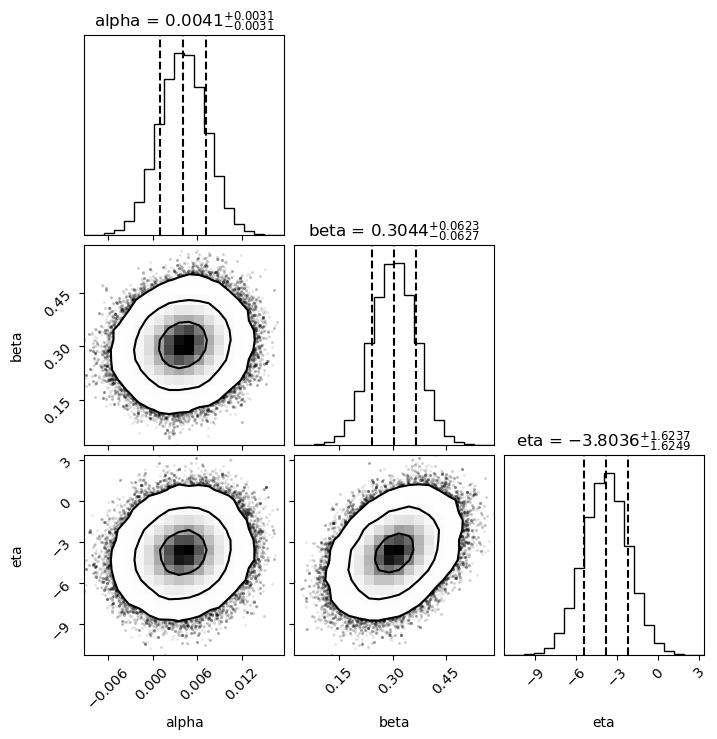

In [10]:
ranges = {}
ranges['alpha'] = [-15, 15]
ranges['beta']  = [-15, 15]
ranges['eta']   = [-15, 15]

p_bestfits['des'] = sample(tau_stats['des'],rowe_stats,ranges)

We now show the corner plot and reduced chi^2 using FLASK data:

In [11]:
import fitsio
rowe_stats_FLASK = {}
stat_file = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/des-y3/dv_mgatti/rho__FLASK_Y3_0_unblind.fits'
covmat=  fitsio.read(stat_file, ext=1)
RHO0P =  fitsio.read(stat_file, ext=2); rowe0 =  RHO0P['VALUE']
RHO0M =  fitsio.read(stat_file, ext=3); rowe0m =  RHO0M['VALUE']
RHO1P =  fitsio.read(stat_file, ext=4); rowe1 =  RHO1P['VALUE']
RHO1M =  fitsio.read(stat_file, ext=5); rowe1m =  RHO1M['VALUE']
RHO2P =  fitsio.read(stat_file, ext=6); rowe2 =  RHO2P['VALUE']
RHO2M =  fitsio.read(stat_file, ext=7); rowe2m =  RHO2M['VALUE']
RHO3P =  fitsio.read(stat_file, ext=8); rowe3 =  RHO3P['VALUE']
RHO3M =  fitsio.read(stat_file, ext=9); rowe3m =  RHO3M['VALUE']
RHO4P =  fitsio.read(stat_file, ext=10); rowe4 =  RHO4P['VALUE']
RHO4M =  fitsio.read(stat_file, ext=11); rowe4m =  RHO4M['VALUE']
RHO5P =  fitsio.read(stat_file, ext=12); rowe5 =  RHO5P['VALUE']
RHO5M =  fitsio.read(stat_file, ext=13); rowe5m =  RHO5M['VALUE']
rowes = [rowe0,rowe1,rowe2,rowe3,rowe4,rowe5]
rowesm = [rowe0m,rowe1m,rowe2m,rowe3m,rowe4m,rowe5m]
for i in range(6):
    theta   = RHO0P['ANG']
    xi_plus = rowes[i]
    xi_minus = rowesm[i]
    xi_err  = np.sqrt(np.diag(covmat[i*len(theta):i+1 * len(theta)]))
    rowe_stats_FLASK[i] = theta, xi_plus,xi_minus, xi_err

/tmp/ipykernel_71734/257000685.py:23: RuntimeWarning: invalid value encountered in sqrt
  xi_err  = np.sqrt(np.diag(covmat[i*len(theta):i+1 * len(theta)]))


In [12]:
stat_file = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/des-y3/dv_mgatti/tau__FLASK_Y3_0_unblind.fits'
covmat =  fitsio.read(stat_file, ext=1)
TAU0P =  fitsio.read(stat_file, ext=2); tau0p =  TAU0P['VALUE']
TAU0M =  fitsio.read(stat_file, ext=3); tau0m =  TAU0M['VALUE']
TAU2P =  fitsio.read(stat_file, ext=4); tau2p =  TAU2P['VALUE']
TAU2M =  fitsio.read(stat_file, ext=5); tau2m =  TAU2M['VALUE']
TAU5P =  fitsio.read(stat_file, ext=6); tau5p =  TAU5P['VALUE']
TAU5M =  fitsio.read(stat_file, ext=7); tau5m =  TAU5M['VALUE']
meanr = TAU0P['ANG']

tau_stats['flask'] = [meanr, tau0p, tau0m, tau2p, tau2m, tau5p, tau5m, covmat]

Computing best-fit alpha, beta, eta


100%|██████████| 5000/5000 [00:45<00:00, 111.04it/s]


(450000, 3)
chi2: 0.7424470039597445


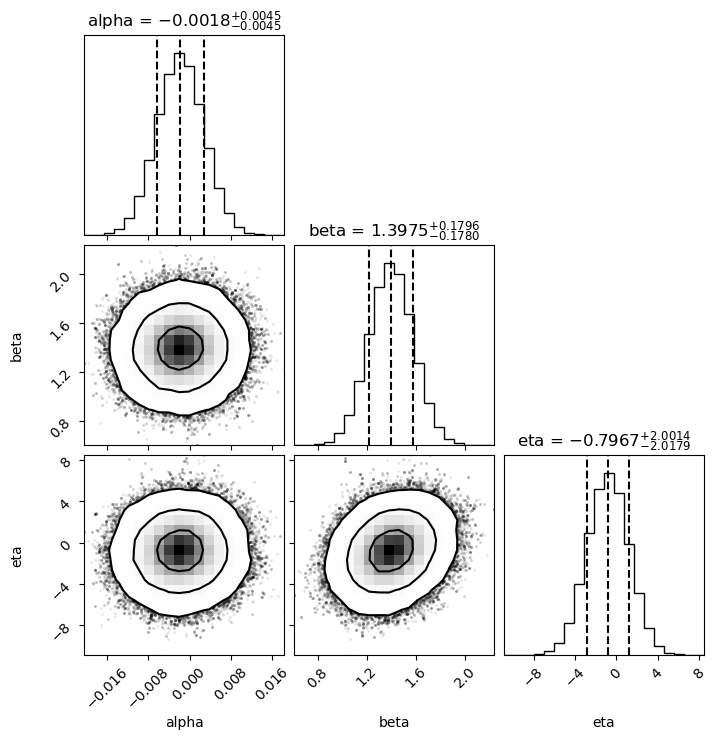

In [13]:
p_bestfits['flask'] = sample(tau_stats['flask'],rowe_stats_FLASK,ranges)

Even in the case of FLASK--we find the eta parameter to have a disproportionately large value for the error, whereas the published value we are hoping to match is eta = -0.5 +/- 0.5

We include the plots of tau+ for visual comparison

In [16]:
p_bestfits['flask']['tau0p'] = p_bestfits['flask']['alpha']['median'] * rowe_stats_FLASK[0][1] + p_bestfits['flask']['beta']['median'] * rowe_stats_FLASK[2][1] + p_bestfits['flask']['eta']['median'] * rowe_stats_FLASK[5][1]

p_bestfits['flask']['tau2p'] = p_bestfits['flask']['alpha']['median'] * rowe_stats_FLASK[2][1] + p_bestfits['flask']['beta']['median'] * rowe_stats_FLASK[1][1]+ p_bestfits['flask']['eta']['median'] * rowe_stats_FLASK[4][1]

p_bestfits['flask']['tau5p'] = p_bestfits['flask']['alpha']['median'] * rowe_stats_FLASK[5][1]+ p_bestfits['flask']['beta']['median'] * rowe_stats_FLASK[4][1]+ p_bestfits['flask']['eta']['median']* rowe_stats_FLASK[3][1] 


p_bestfits['des']['tau0p'] = p_bestfits['des']['alpha']['median'] * rowe_stats[0][1] + p_bestfits['des']['beta']['median'] * rowe_stats[2][1] + p_bestfits['des']['eta']['median'] * rowe_stats[5][1]

p_bestfits['des']['tau2p'] = p_bestfits['des']['alpha']['median'] * rowe_stats[2][1] + p_bestfits['des']['beta']['median'] * rowe_stats[1][1]+ p_bestfits['des']['eta']['median'] * rowe_stats[4][1]

p_bestfits['des']['tau5p'] = p_bestfits['des']['alpha']['median'] * rowe_stats[5][1]+ p_bestfits['des']['beta']['median'] * rowe_stats[4][1]+ p_bestfits['des']['eta']['median']* rowe_stats[3][1] 


Text(0, 0.5, '$\\theta \\times \\tau_{5}$')

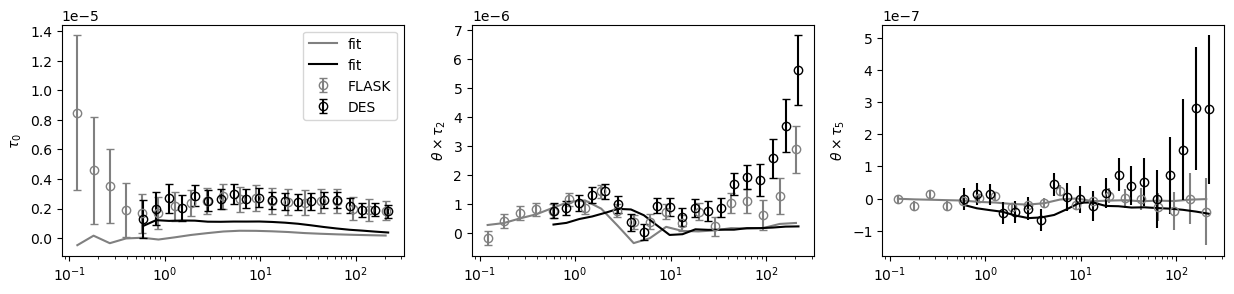

In [18]:
fig, axs = plt.subplots(1,3,figsize=[15,3])
ax1,ax2,ax3 = axs.flatten()

ax1.errorbar(tau_stats['flask'][0],
             tau_stats['flask'][1],
             np.sqrt(np.diag(tau_stats['flask'][7][0:20,0:20])),
             color='grey',marker='o',mfc='None',ls='None',capsize=3,label='FLASK')

ax1.plot(tau_stats['flask'][0],
         p_bestfits['flask']['tau0p'],color='grey',label='fit'
        )

ax1.errorbar(tau_stats['des'][0],
             tau_stats['des'][1],
             np.sqrt(np.diag(tau_stats['des'][7][0:20,0:20])),
             color='black',marker='o',mfc='None',ls='None',capsize=3,label='DES')

ax1.plot(tau_stats['des'][0],
         p_bestfits['des']['tau0p'],color='black',label='fit'
        )

ax1.set_xscale('log')
ax1.set_ylabel(r'$\tau_{0}$')
ax1.legend()

ax2.errorbar(tau_stats['flask'][0],
             tau_stats['flask'][0] * tau_stats['flask'][3],
             tau_stats['flask'][0] * np.sqrt(np.diag(tau_stats['flask'][7][40:60,40:60])),
             color='grey',marker='o',mfc='None',ls='None',capsize=3,label='Tau, full cov')
ax2.plot(tau_stats['flask'][0],
         tau_stats['flask'][0]*p_bestfits['flask']['tau2p'],color='grey'
        )

ax2.errorbar(tau_stats['des'][0],
             tau_stats['des'][0] * tau_stats['des'][3],
             tau_stats['des'][0] * np.sqrt(np.diag(tau_stats['des'][7][40:60,40:60])),
             color='black',marker='o',mfc='None',ls='None',capsize=3,label='DES')
ax2.plot(tau_stats['des'][0],
         tau_stats['des'][0]*p_bestfits['des']['tau2p'],color='black'
        )

ax2.set_xscale('log')
ax2.set_ylabel(r'$\theta \times \tau_{2}$')

ax3.errorbar(tau_stats['flask'][0],
             tau_stats['flask'][0] * tau_stats['flask'][5],
             tau_stats['flask'][0] * np.sqrt(np.diag(tau_stats['flask'][7][80:100,80:100])),
             color='grey',marker='o',mfc='None',ls='None',label='TXPipe')
ax3.plot(tau_stats['flask'][0],
         tau_stats['flask'][0]*p_bestfits['flask']['tau5p'],color='grey'
        )
ax3.errorbar(tau_stats['des'][0],
             tau_stats['des'][0] * tau_stats['des'][5],
             tau_stats['des'][0] * np.sqrt(np.diag(tau_stats['des'][7][80:100,80:100])),
             color='black',marker='o',mfc='None',ls='None',label='DES')
ax3.plot(tau_stats['des'][0],
         tau_stats['des'][0]*p_bestfits['des']['tau5p'],color='black'
        )
ax3.set_xscale('log')
ax3.set_ylabel(r'$\theta \times \tau_{5}$')
